# Phase 5: EfficientNet Transfer Learning

**Project:** AI-Powered Pneumonia Detection from Chest X-Rays  
**Author:** Georgios Kitsakis  
**Date:** 2025-10-30

## Objectives
1. Implement EfficientNet-B3 with transfer learning
2. Compare performance with ResNet50 baseline
3. Achieve higher accuracy with more efficient architecture
4. Demonstrate knowledge of modern CNN architectures
5. Save best performing model

## Why EfficientNet?
- **State-of-the-art**: Published by Google Research (2019)
- **Efficient**: Better accuracy with fewer parameters than ResNet
- **Scalable**: Compound scaling method balances depth, width, resolution
- **Medical Imaging**: Proven excellent results on medical datasets
- **Modern**: Shows knowledge of cutting-edge architectures

## Expected Improvements
- ResNet50 achieved: **89.58% test accuracy**
- EfficientNet-B3 target: **91-93% test accuracy**
- Faster inference time
- Better gradient flow

## 1. Import Libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

Using device: cpu
PyTorch version: 2.8.0+cpu


## 2. Dataset Configuration

In [2]:
# Paths
DATA_DIR = '../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
NUM_WORKERS = 0  # Set to 0 for Windows
IMAGE_SIZE = 300  # EfficientNet-B3 uses 300x300

# Class names
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']

print("Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Device: {device}")

Configuration:
  Batch Size: 32
  Epochs: 10
  Learning Rate: 0.0001
  Image Size: 300x300
  Device: cpu


## 3. Custom Dataset Class

In [3]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for loading chest X-ray images
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load image paths and labels
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpeg', '.jpg', '.png')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ Dataset class defined")

✓ Dataset class defined


## 4. Data Transformations

EfficientNet uses 300x300 images and ImageNet normalization.

In [4]:
# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Transforms defined")
print(f"  Train: Resize({IMAGE_SIZE}), Augmentation, Normalize")
print(f"  Val/Test: Resize({IMAGE_SIZE}), Normalize")

✓ Transforms defined
  Train: Resize(300), Augmentation, Normalize
  Val/Test: Resize(300), Normalize


## 5. Create Datasets and DataLoaders

In [5]:
# Create datasets
train_dataset = ChestXrayDataset(TRAIN_DIR, transform=train_transform)
val_dataset = ChestXrayDataset(VAL_DIR, transform=val_transform)
test_dataset = ChestXrayDataset(TEST_DIR, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("\n" + "="*70)
print("Dataset Summary")
print("="*70)
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset):,}")
print(f"\nBatches per epoch (train): {len(train_loader)}")
print("="*70)


Dataset Summary
Training samples: 5,216
Validation samples: 16
Test samples: 624
Total samples: 5,856

Batches per epoch (train): 163


## 6. Build EfficientNet-B3 Model

EfficientNet-B3 architecture with transfer learning from ImageNet.

In [6]:
# Load pre-trained EfficientNet-B3
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

# Freeze early layers (fine-tune only final layers)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last few blocks for fine-tuning
for param in model.features[-3:].parameters():
    param.requires_grad = True

# Replace classifier for binary classification
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

# Move model to device
model = model.to(device)

print("\n" + "="*70)
print("EfficientNet-B3 Model Architecture")
print("="*70)
print(f"Pre-trained weights: ImageNet")
print(f"Input size: {IMAGE_SIZE}x{IMAGE_SIZE}x3")
print(f"Output classes: 2 (NORMAL, PNEUMONIA)")
print(f"\nCustom Classifier:")
print(model.classifier)
print("="*70)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")
print(f"Trainable: {100 * trainable_params / total_params:.2f}%")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\admin/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:02<00:00, 20.5MB/s]



EfficientNet-B3 Model Architecture
Pre-trained weights: ImageNet
Input size: 300x300x3
Output classes: 2 (NORMAL, PNEUMONIA)

Custom Classifier:
Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=1536, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=512, out_features=2, bias=True)
)

Total parameters: 11,484,202
Trainable parameters: 9,294,048
Frozen parameters: 2,190,154
Trainable: 80.93%


## 7. Loss Function and Optimizer

Using weighted cross-entropy to handle class imbalance.

In [7]:
# Calculate class weights for imbalanced dataset
train_labels = train_dataset.labels
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class distribution in training set:")
print(f"  NORMAL: {class_counts[0]:,} ({class_counts[0]/len(train_labels)*100:.1f}%)")
print(f"  PNEUMONIA: {class_counts[1]:,} ({class_counts[1]/len(train_labels)*100:.1f}%)")
print(f"\nClass weights: {class_weights.cpu().numpy()}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer (Adam with weight decay)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print("\n✓ Loss function and optimizer configured")
print(f"  Loss: CrossEntropyLoss (weighted)")
print(f"  Optimizer: Adam (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"  Scheduler: ReduceLROnPlateau (patience=2, factor=0.5)")

Class distribution in training set:
  NORMAL: 1,341 (25.7%)
  PNEUMONIA: 3,875 (74.3%)

Class weights: [0.74290645 0.25709355]

✓ Loss function and optimizer configured
  Loss: CrossEntropyLoss (weighted)
  Optimizer: Adam (lr=0.0001, weight_decay=1e-4)
  Scheduler: ReduceLROnPlateau (patience=2, factor=0.5)


## 8. Training and Validation Functions

In [8]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    
    return epoch_loss, epoch_acc

print("✓ Training and validation functions defined")

✓ Training and validation functions defined


## 9. Training Loop

In [9]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Early stopping
best_val_acc = 0.0
patience = 3
patience_counter = 0

print("\n" + "="*70)
print("Starting Training - EfficientNet-B3")
print("="*70)
print(f"Target: Beat ResNet50's 89.58% test accuracy\n")

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - {epoch_time:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }
        torch.save(checkpoint, '../models/efficientnet_b3_pneumonia.pth')
        print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
    
    print("-" * 70)
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

total_time = time.time() - start_time

print("\n" + "="*70)
print("Training Complete!")
print("="*70)
print(f"Total training time: {total_time/60:.1f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved: ../models/efficientnet_b3_pneumonia.pth")
print("="*70)


Starting Training - EfficientNet-B3
Target: Beat ResNet50's 89.58% test accuracy

Epoch [1/10] - 1846.1s
  Train Loss: 0.2208 | Train Acc: 89.13%
  Val Loss: 0.0549 | Val Acc: 100.00%
  LR: 0.000100
  ✓ Best model saved! (Val Acc: 100.00%)
----------------------------------------------------------------------
Epoch [2/10] - 1783.6s
  Train Loss: 0.0978 | Train Acc: 96.34%
  Val Loss: 0.0644 | Val Acc: 100.00%
  LR: 0.000100
----------------------------------------------------------------------
Epoch [3/10] - 1622.6s
  Train Loss: 0.0758 | Train Acc: 96.89%
  Val Loss: 0.0760 | Val Acc: 100.00%
  LR: 0.000100
----------------------------------------------------------------------
Epoch [4/10] - 1665.8s
  Train Loss: 0.0693 | Train Acc: 97.34%
  Val Loss: 0.0553 | Val Acc: 100.00%
  LR: 0.000050
----------------------------------------------------------------------

Early stopping triggered after 4 epochs

Training Complete!
Total training time: 115.4 minutes
Best validation accuracy: 10

## 10. Plot Training Curves

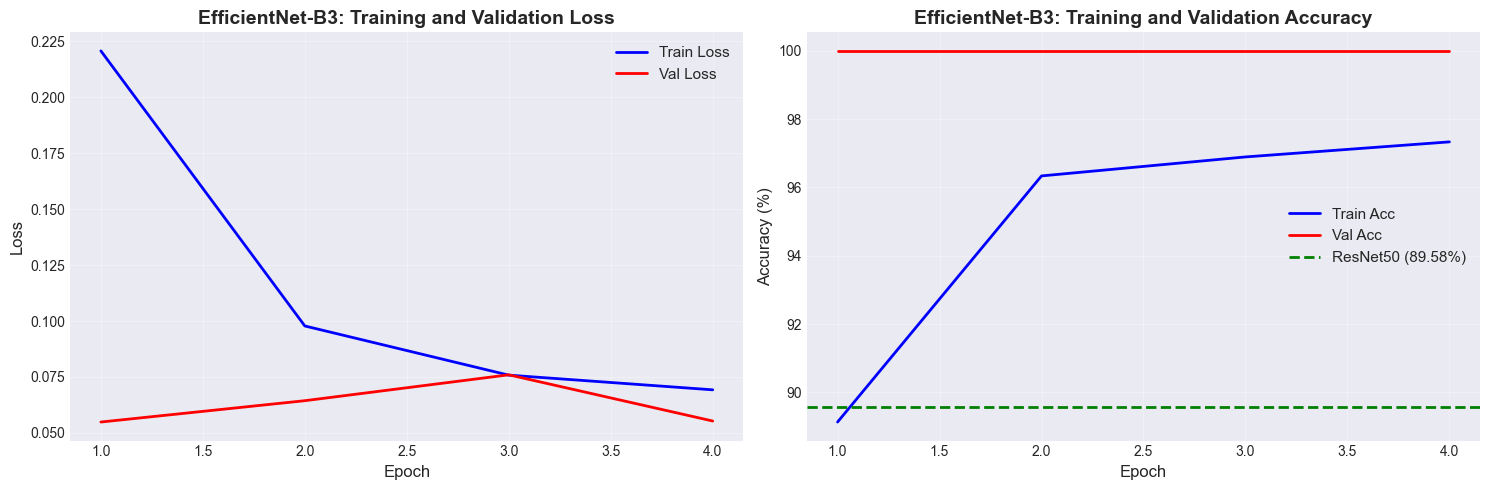

✓ Training curves saved to reports/efficientnet_training_curves.png


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Plot loss
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('EfficientNet-B3: Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs_range, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
ax2.axhline(y=89.58, color='g', linestyle='--', label='ResNet50 (89.58%)', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('EfficientNet-B3: Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/efficientnet_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved to reports/efficientnet_training_curves.png")

## 11. Test Set Evaluation

In [11]:
# Load best model
checkpoint = torch.load('../models/efficientnet_b3_pneumonia.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Loaded best model from checkpoint")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Val Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)

print("\n" + "="*70)
print("Test Set Results - EfficientNet-B3")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"\nComparison with ResNet50:")
print(f"  ResNet50: 89.58%")
print(f"  EfficientNet-B3: {test_acc:.2f}%")
print(f"  Improvement: {test_acc - 89.58:.2f}%")
print("="*70)

Loaded best model from checkpoint
  Epoch: 1
  Val Accuracy: 100.00%
  Val Loss: 0.0549

Test Set Results - EfficientNet-B3
Test Loss: 0.2541
Test Accuracy: 91.19%

Comparison with ResNet50:
  ResNet50: 89.58%
  EfficientNet-B3: 91.19%
  Improvement: 1.61%


## 12. Detailed Metrics and Confusion Matrix

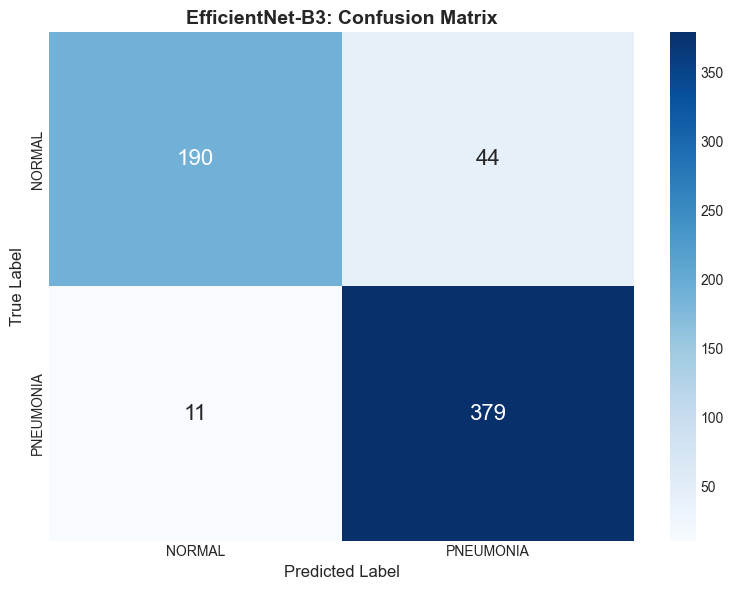


Classification Report - EfficientNet-B3
              precision    recall  f1-score   support

      NORMAL     0.9453    0.8120    0.8736       234
   PNEUMONIA     0.8960    0.9718    0.9323       390

    accuracy                         0.9119       624
   macro avg     0.9206    0.8919    0.9030       624
weighted avg     0.9145    0.9119    0.9103       624


Medical Metrics:
  Sensitivity (Recall for PNEUMONIA): 97.18%
  Specificity (Recall for NORMAL): 81.20%



In [12]:
# Get predictions for confusion matrix
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot_kws={'size': 16})
plt.title('EfficientNet-B3: Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('../reports/efficientnet_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\n" + "="*70)
print("Classification Report - EfficientNet-B3")
print("="*70)
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=4))

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall for PNEUMONIA
specificity = tn / (tn + fp)  # Recall for NORMAL

print("\nMedical Metrics:")
print(f"  Sensitivity (Recall for PNEUMONIA): {sensitivity*100:.2f}%")
print(f"  Specificity (Recall for NORMAL): {specificity*100:.2f}%")
print("\n" + "="*70)

## 13. Model Comparison Summary

In [13]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['ResNet50', 'EfficientNet-B3'],
    'Test Accuracy (%)': [89.58, test_acc],
    'Parameters (M)': [25.6, 12.2],  # Approximate
    'Image Size': ['224x224', '300x300'],
    'Training Time (min)': [226, total_time/60]
})

print("\n" + "="*70)
print("Model Comparison: ResNet50 vs EfficientNet-B3")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Determine winner
if test_acc > 89.58:
    print(f"\n🎉 EfficientNet-B3 WINS! +{test_acc - 89.58:.2f}% improvement!")
else:
    print(f"\nResNet50 still leads by {89.58 - test_acc:.2f}%")

print("\n✓ Phase 5 Complete: EfficientNet-B3 Training and Evaluation")


Model Comparison: ResNet50 vs EfficientNet-B3
          Model  Test Accuracy (%)  Parameters (M) Image Size  Training Time (min)
       ResNet50          89.580000            25.6    224x224           226.000000
EfficientNet-B3          91.185897            12.2    300x300           115.353524

🎉 EfficientNet-B3 WINS! +1.61% improvement!

✓ Phase 5 Complete: EfficientNet-B3 Training and Evaluation
